# Objectif:

- Réaliser l'entrainement du modèle, en cross validation
- Tester le modèle sur le jeu de donnée d'entrainement 
- Puis le sauvegarder en objet pickle pour l'incorporer facilement à l'app streamlit de prédiction

In [24]:
import this

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from chemotools.scatter import StandardNormalVariate
from chemotools.derivative import SavitzkyGolay
from chemotools.feature_selection import RangeCut
import sys
sys.path.append('/Users/douati/Documents/GitHub/Spectroscopy-project-')
from module_projet.pca_plot import plot_pca_variance,plot_pca_score
from module_projet.modelisation_plot import plot_residuals,plot_residual_distribution,plot_predictions
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2

# Chargement des données 

In [26]:
# chargement des données
with open('../../data/processed/mmc3.pkl', 'rb') as f:
    Xtrain, ytrain, Xtest, ytest, X, wavelengths = pickle.load(f)

# Visualisation des données 

## Visualisation des targets

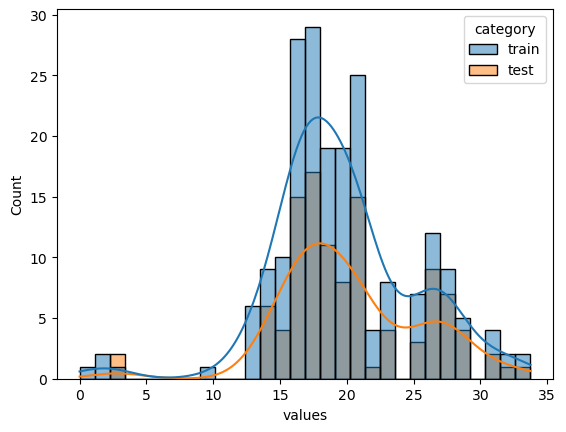

In [27]:
# Concaténation des deux
y = pd.concat([pd.Series(ytrain.flatten()), pd.Series(ytest.flatten())], ignore_index=True)
#X = pd.concat([pd.DataFrame(Xtrain),pd.DataFrame(Xtest)], ignore_index=True)
y = y.values
index = np.arange(y.shape[0])
mask_train = index < ytrain.shape[0]  # Vrai pour les indices correspondant à y_train
mask_test = ~mask_train                # Inverse du masque d'entraînement
# Ajout des catégories dans la base
y = pd.DataFrame({'values': y, 'category': np.where(mask_train, 'train', 'test')})

sns.histplot(y, x='values', hue='category', bins=30, kde=True)
categories = y['category']

### Conclusion

La repartitioin de la cible est la même ytrain et ytest

## visualisation des spectres

Text(0.5, 1.0, 'Spectres : Données d’entraînement et de test')

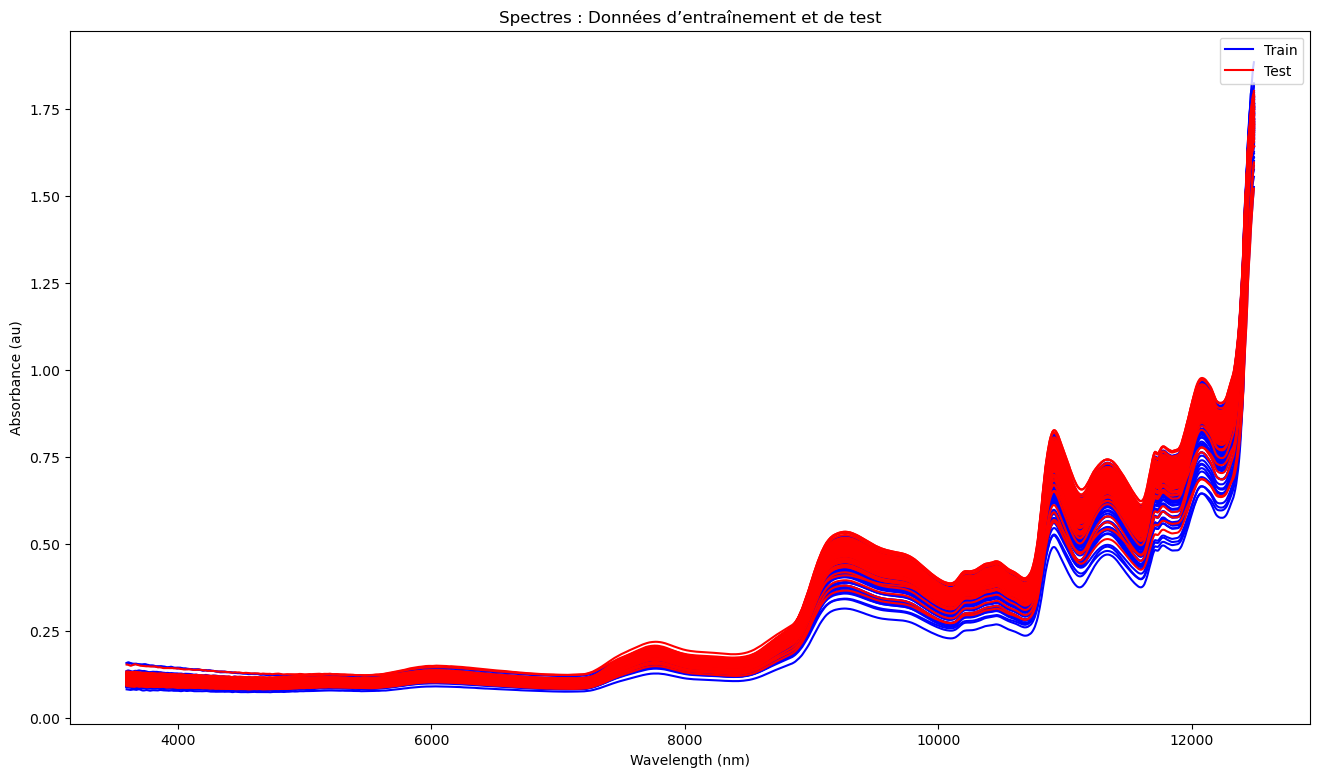

In [28]:
plt.figure(figsize=(16,9))
# Tracer les données d'entraînement (Xtrain) avec un label
for i in range(len(Xtrain)):
    plt.plot(wavelengths, Xtrain[i], color='blue', label='Train' if i == 0 else "")

# Tracer les données de test (Xtest) avec un label
for i in range(len(Xtest)):
    plt.plot(wavelengths, Xtest[i], color='red', label='Test' if i == 0 else "")

# Ajouter des étiquettes pour les axes
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance (au)')

# Ajouter une légende
plt.legend(loc='upper right')  # Ajustez la position si nécessaire
plt.title('Spectres : Données d’entraînement et de test')

# Prétraitements

On va réaliser un preprocessing sur les données : 

L'article recommande de réaliser les prétraitements suivants pour les modélisations :
    - SNV
    - 1ère dérivée
    - 2nd dérivée

Réalisons les visualisations :

## SNV

Text(0.5, 1.0, 'Spectres : Données d’entraînement et de test - SNV ')

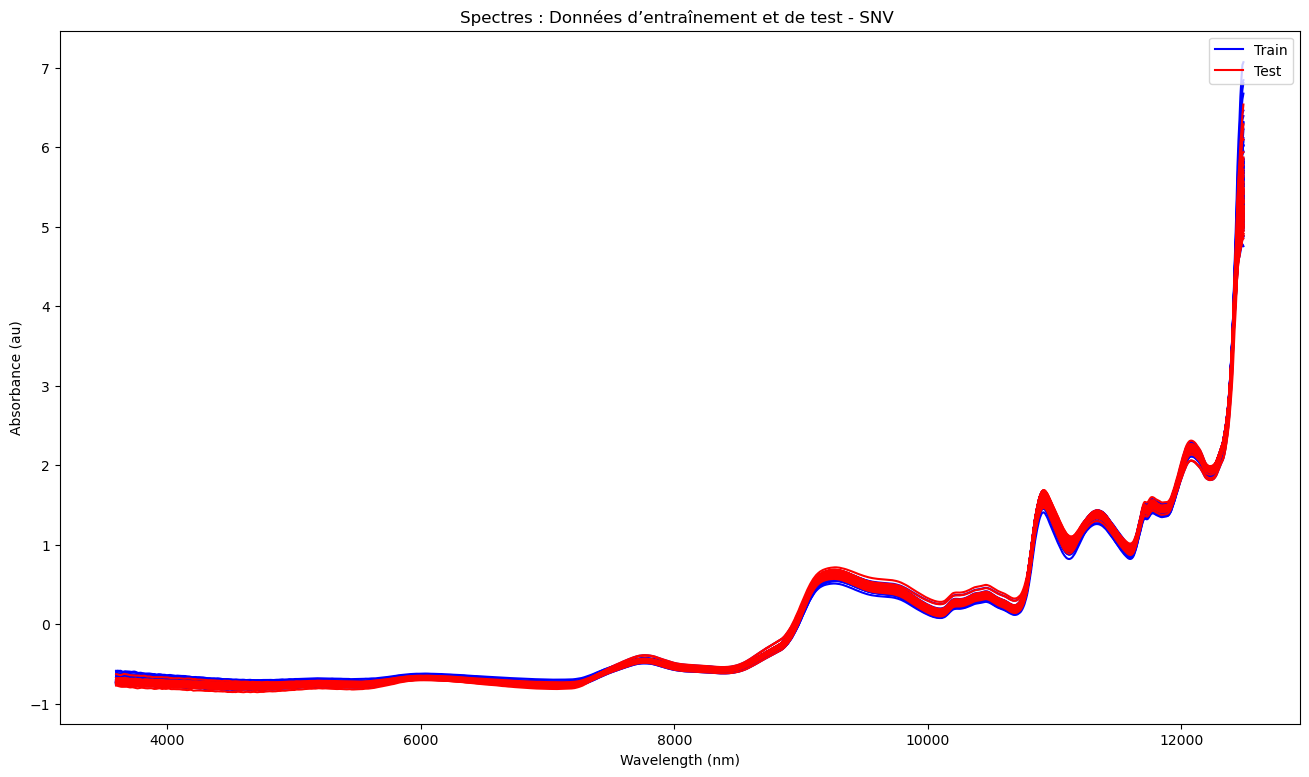

In [29]:
# prétraitements
snv = StandardNormalVariate()

plt.figure(figsize=(16,9))
# Tracer les données d'entraînement (Xtrain) avec un label
for i in range(len(Xtrain)):
    plt.plot(wavelengths, snv.fit_transform(Xtrain)[i], color='blue', label='Train' if i == 0 else "")

# Tracer les données de test (Xtest) avec un label
for i in range(len(Xtest)):
    plt.plot(wavelengths, snv.fit_transform(Xtest)[i], color='red', label='Test' if i == 0 else "")

# Ajouter des étiquettes pour les axes
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance (au)')

# Ajouter une légende
plt.legend(loc='upper right')  # Ajustez la position si nécessaire
plt.title('Spectres : Données d’entraînement et de test - SNV ')

## 1ère dérivée

In [30]:
# prétraitement
fisrt_deriv = SavitzkyGolay(15,2,1)

Text(0.5, 1.0, 'Spectres : Données d’entraînement et de test - dérivée première')

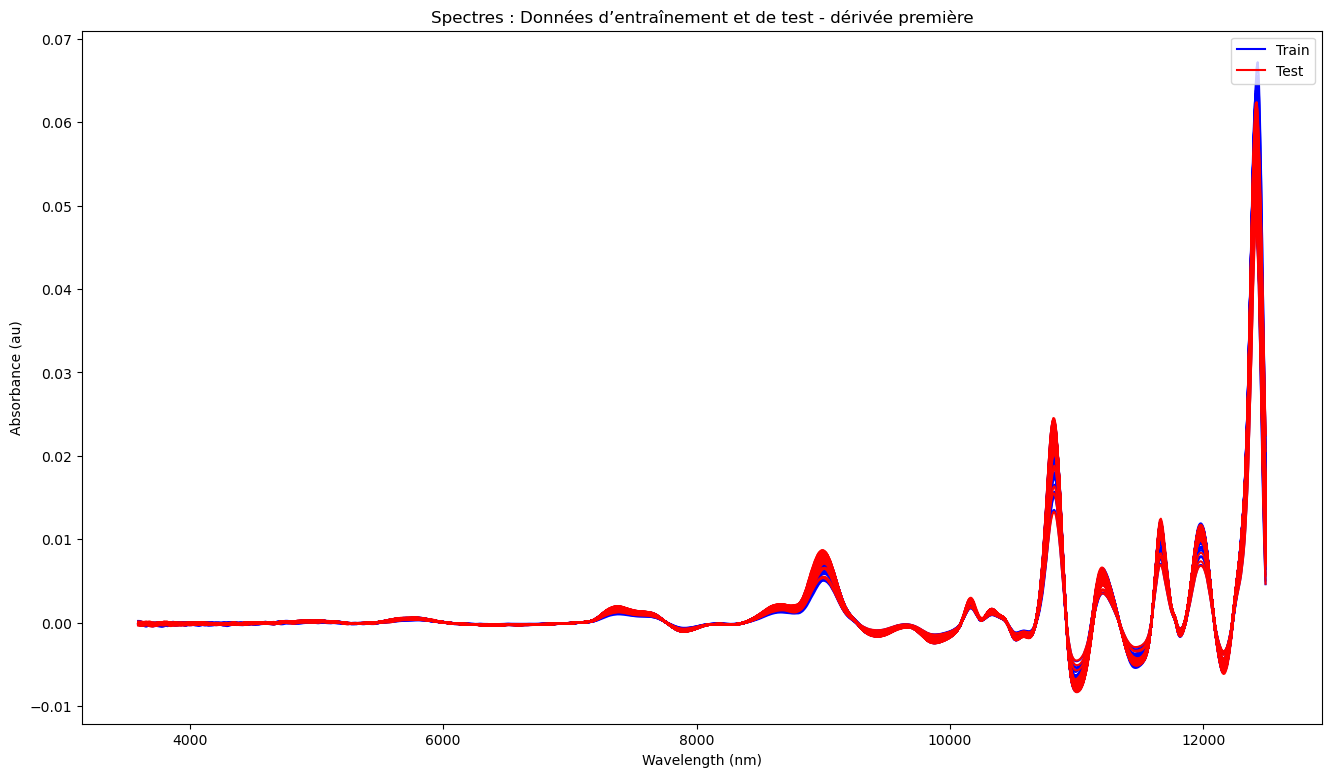

In [31]:
plt.figure(figsize=(16,9))
# Tracer les données d'entraînement (Xtrain) avec un label
for i in range(len(Xtrain)):
    plt.plot(wavelengths, fisrt_deriv.fit_transform(Xtrain)[i], color='blue', label='Train' if i == 0 else "")

# Tracer les données de test (Xtest) avec un label
for i in range(len(Xtest)):
    plt.plot(wavelengths, fisrt_deriv.fit_transform(Xtest)[i], color='red', label='Test' if i == 0 else "")

# Ajouter des étiquettes pour les axes
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance (au)')

# Ajouter une légende
plt.legend(loc='upper right')  # Ajustez la position si nécessaire
plt.title('Spectres : Données d’entraînement et de test - dérivée première')

## 2nde dérivée 

Text(0.5, 1.0, 'Spectres : Données d’entraînement et de test - dérivée seconde')

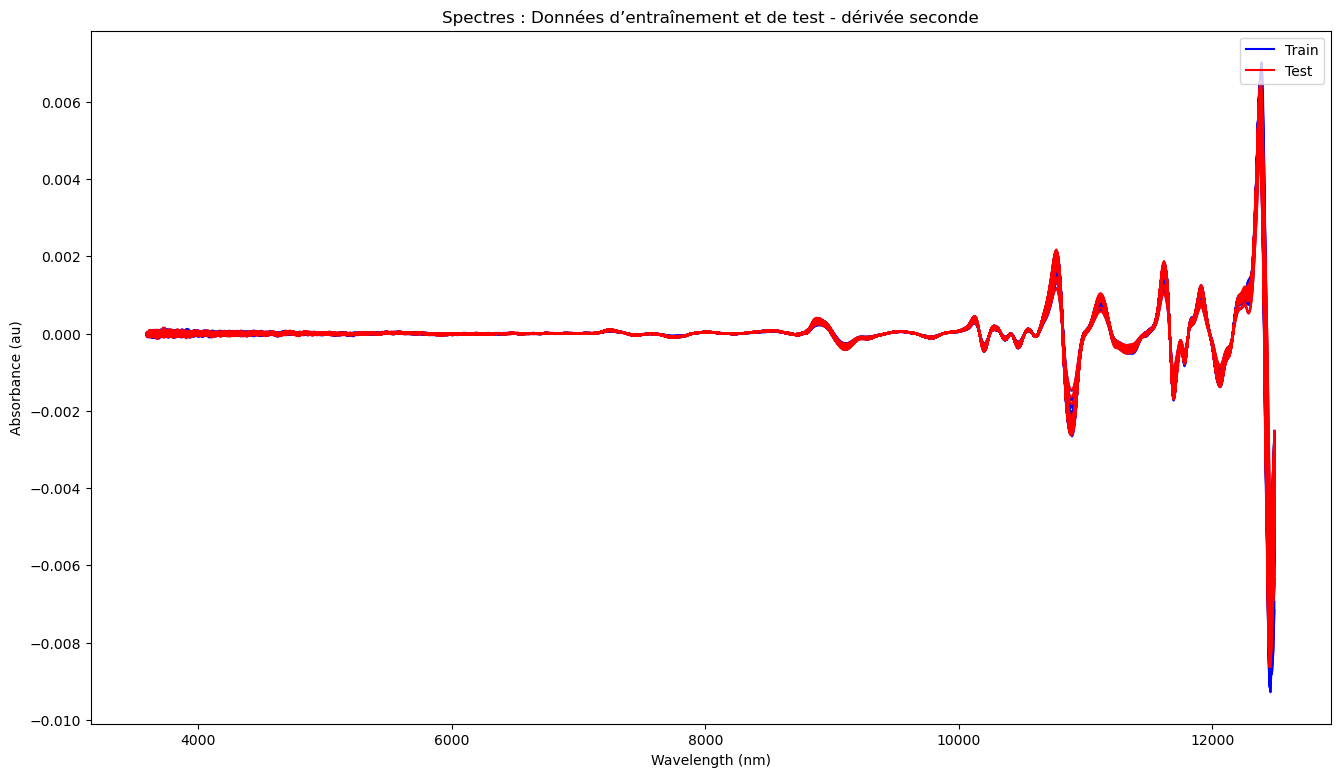

In [32]:
# prétraitement
second_deriv = SavitzkyGolay(15,2,2)

plt.figure(figsize=(16,9))
# Tracer les données d'entraînement (Xtrain) avec un label
for i in range(len(Xtrain)):
    plt.plot(wavelengths, second_deriv.fit_transform(Xtrain)[i], color='blue', label='Train' if i == 0 else "")

# Tracer les données de test (Xtest) avec un label
for i in range(len(Xtest)):
    plt.plot(wavelengths, second_deriv.fit_transform(Xtest)[i], color='red', label='Test' if i == 0 else "")

# Ajouter des étiquettes pour les axes
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance (au)')

# Ajouter une légende
plt.legend(loc='upper right')  # Ajustez la position si nécessaire
plt.title('Spectres : Données d’entraînement et de test - dérivée seconde')

# Modélisation

- on veut réaliser une modélisation pls classique en chimiométrie

## Pls SNV

In [33]:
np.arange(1, 10).flatten()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [34]:
np.random.seed(0)
pls_snv = make_pipeline(StandardNormalVariate(), SavitzkyGolay(15,2,2),PLSRegression(scale=False))
param_grid = {'plsregression__n_components': np.arange(1, 30)}
grid_search = GridSearchCV(pls_snv, param_grid, cv=5,scoring='neg_mean_squared_error')
#entrainement
grid_search.fit(Xtrain, ytrain)

#meilleur score et paramètre
print("les meilleurs paramètres sont : ", grid_search.best_params_)
print("le meilleur score est : ",np.abs(grid_search.best_score_))


les meilleurs paramètres sont :  {'plsregression__n_components': 21}
le meilleur score est :  15.024079414244387


Text(0.5, 1.0, 'Cross validation results')

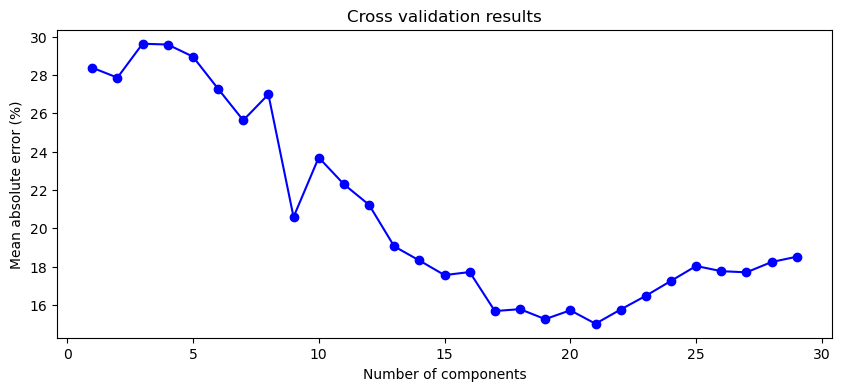

In [35]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(param_grid['plsregression__n_components'].flatten(), np.abs(grid_search.cv_results_['mean_test_score']), marker='o', color='b')
ax.set_xlabel('Number of components')
ax.set_ylabel('Mean absolute error (%)')
ax.set_title('Cross validation results')

### Commentaires sur le choix des composantes :

- Pour un modèle plus générale : il serait intéressant de s'arrêter à 17-19 
- Pour mon cas ici vu que c'est juste un exercice on va aller à 21 le meilleur paramètres
- J'ai testé différents préprocessing les meilleurs résultats sont obtenus avec : 
    - SNV + Dérivée seconde 

In [36]:
# prediction sur le jeu d'entrainement
np.random.seed(0)
pls_snv = make_pipeline(StandardNormalVariate(), PLSRegression(n_components=grid_search.best_params_['plsregression__n_components'], scale=False))
pls_snv.fit(Xtrain, ytrain)
y_pred_train = pls_snv.predict(Xtrain)

# Paramètres qualité de la prédiction
residuals = ytrain - y_pred_train
bias = np.mean(residuals)
rmse = np.sqrt(np.mean(residuals**2))
r2 = 1 - np.sum(residuals**2) / np.sum((ytrain - np.mean(ytrain))**2)  

print(f"Biais : {bias:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R2 : {r2:.2f}")


Biais : 0.00
RMSE : 1.42
R2 : 0.93


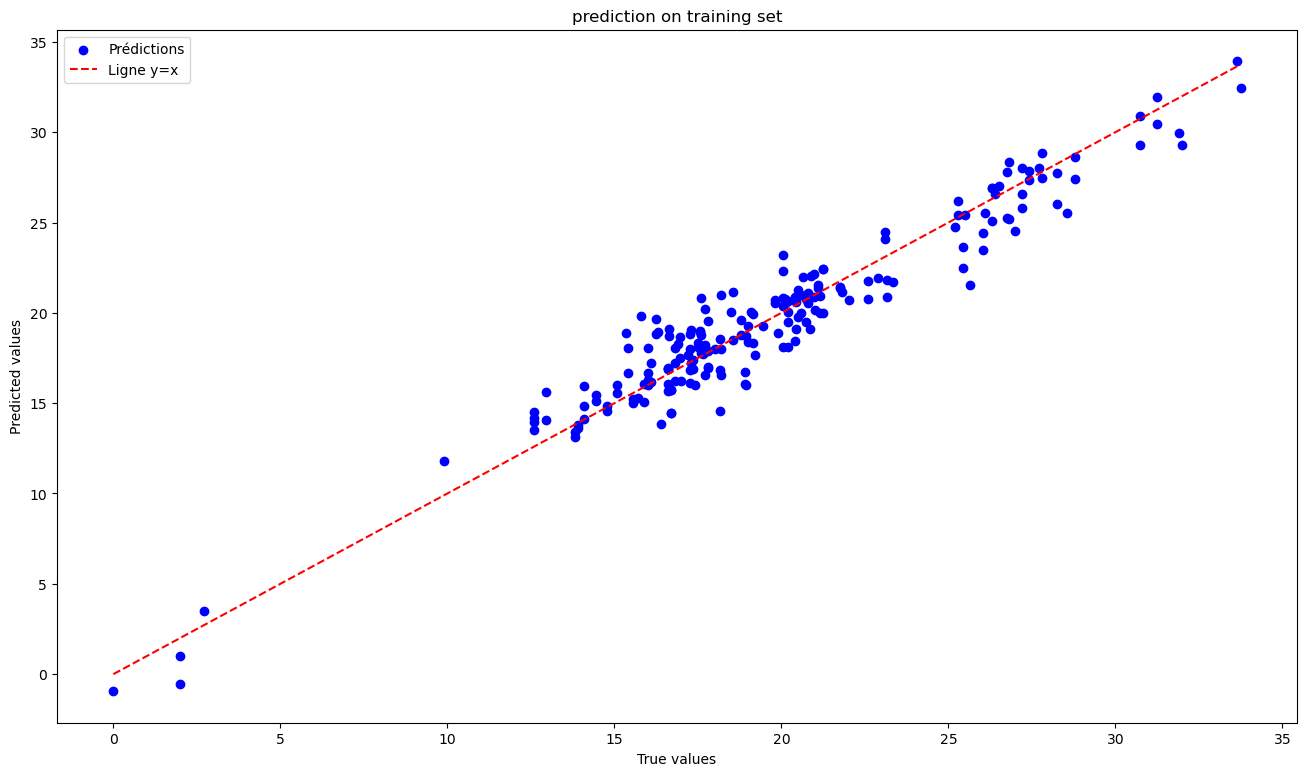

In [37]:
plot_predictions(ytrain, y_pred_train, title='prediction on training set')

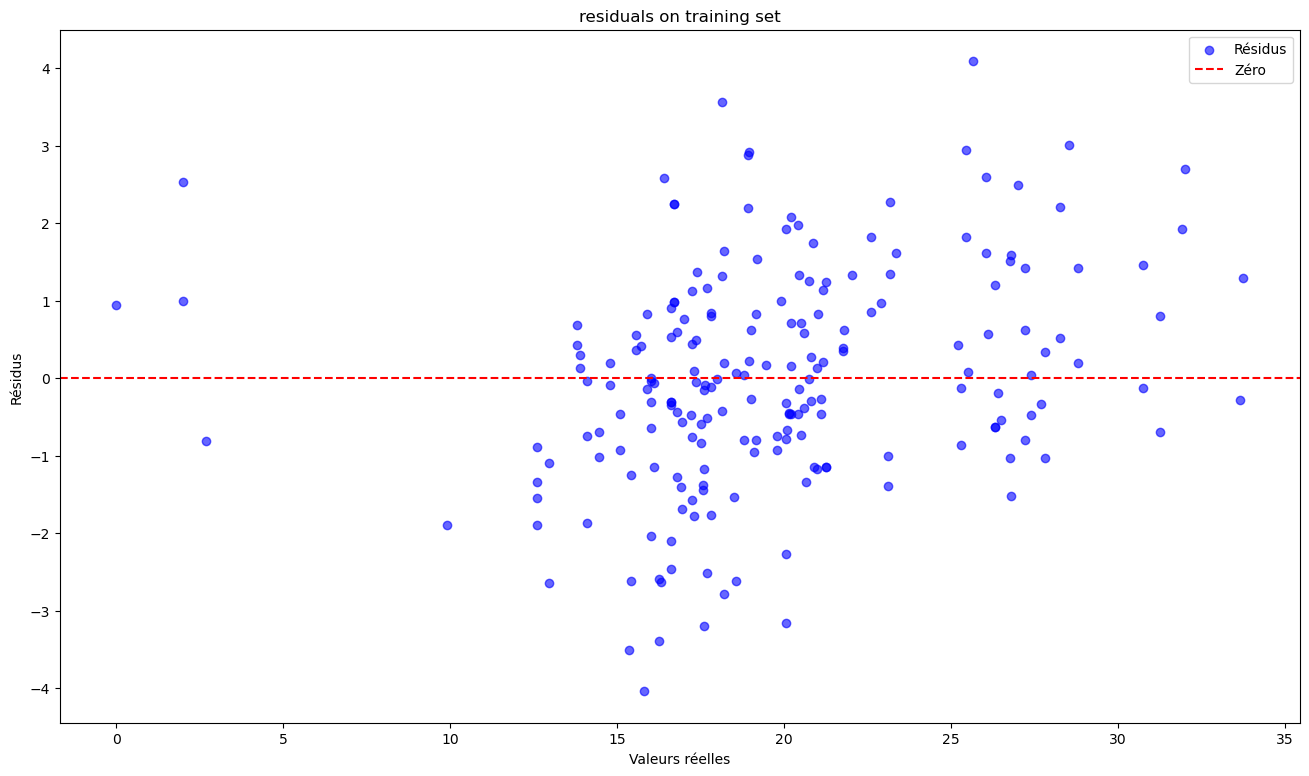

In [38]:
# plot residus
plot_residuals(y_values=ytrain,residuals=residuals.flatten(), title='residuals on training set')

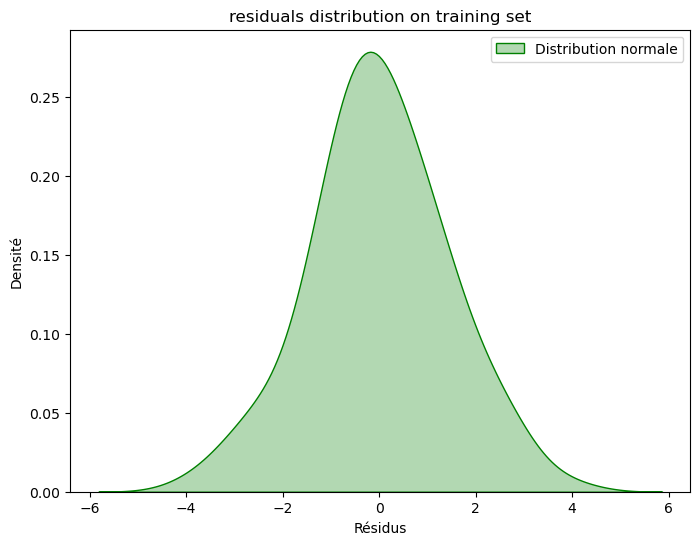

In [39]:
# plot residus distribution
plot_residual_distribution(residuals.flatten(), title='residuals distribution on training set')

In [40]:
# Prédiction sur le jeu de test
y_pred_test = pls_snv.predict(Xtest)

# Paramètres qualité de la prédiction
residuals = ytest - y_pred_test
bias = np.mean(residuals)
rmse = np.sqrt(np.mean(residuals**2))
r2 = 1 - np.sum(residuals**2) / np.sum((ytest - np.mean(ytest))**2)

print(f"Biais : {bias:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R2 : {r2:.2f}")


Biais : 0.05
RMSE : 2.59
R2 : 0.75


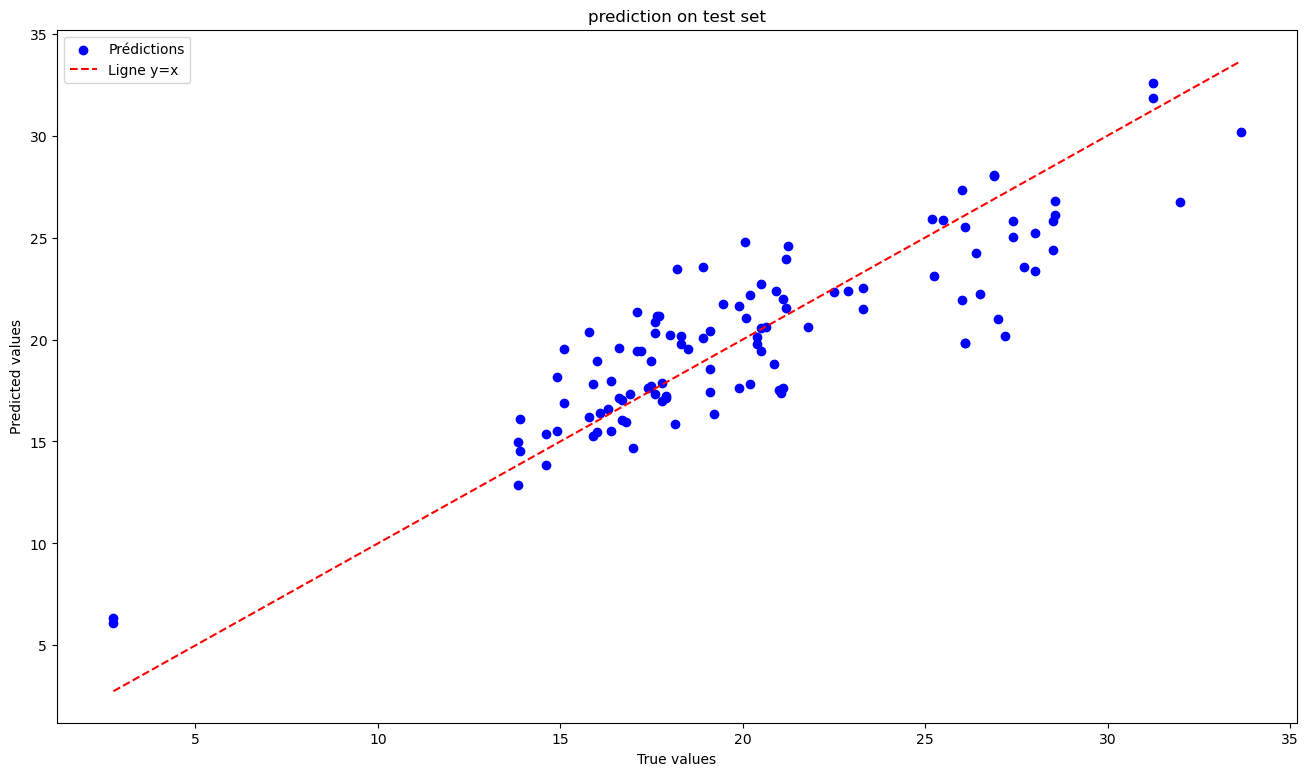

In [41]:
plot_predictions(ytest, y_pred_test, title='prediction on test set')

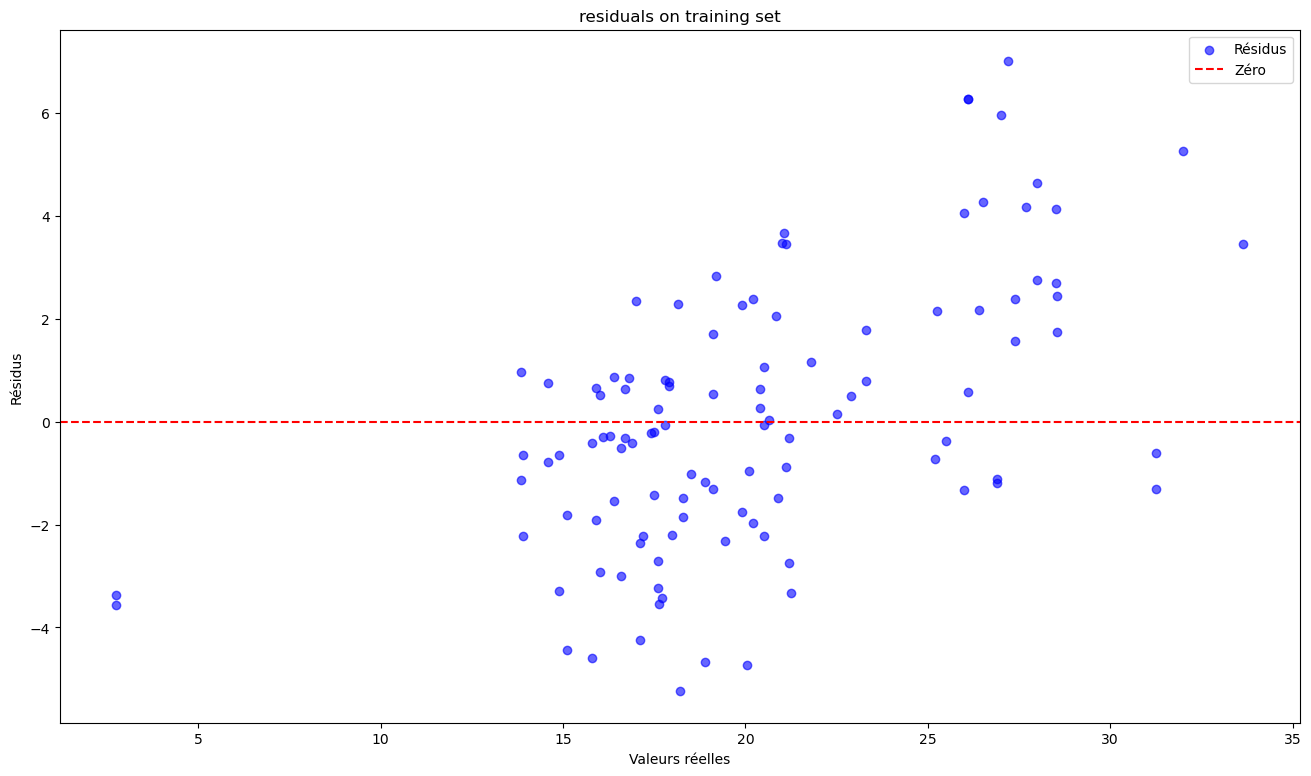

In [42]:
# plot residus
plot_residuals(y_values=ytest,residuals = residuals.flatten(), title='residuals on training set')

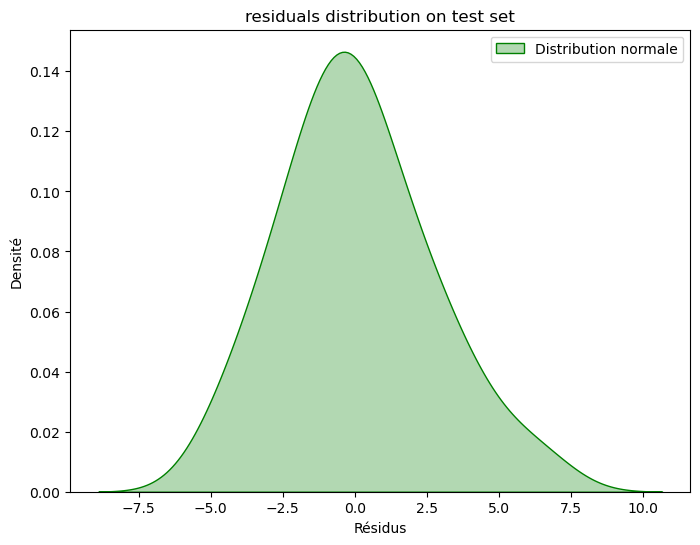

In [43]:
# plot residus distribution
plot_residual_distribution(residuals.flatten(), title='residuals distribution on test set')

In [46]:
# enregistrement du modèle
with open('../../data/model/pls_snv.pkl', 'wb') as f:
    pickle.dump(pls_snv, f)